# Chapter 15 Autoencoders

Autoencoders attempt to reproduce their input as output, but under certain limiting conditions which end up making them useful. Because of these constraints, they end up learning more efficient representations of the data. This makes them useful for dimensionality reduction, feature extraction, unsupervised pretraining of DNNs, and for generating novel data which resembles the input they were trained on. 

## Efficient Data Representations

An autoencoder is made up an *encoder*, also called a *recognition network*, which transforms the data into an alternate representation, and a *decoder* or *generative network* which attempts to reproduce the original input. This output is called a *reconstruction*, and the the autoencoder's associated cost function is a measure of the difference between the original input and the reconstructed output. When the the new representation has fewer dimensions than the original data, the autoencoder is called *undercomplete*. 

## Performing PCA with an Undercomplete Linear Autoencoder

It turns out that an autoencoder with linear activations and an MSE cost function is equivalent to PCA! Let's build that now.

In [1]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from functools import partial

In [2]:
from sklearn.preprocessing import StandardScaler

# Generate data
m = 200
w1, w2 = 0.1, 0.3
noise = 0.1

angles = np.random.rand(m) * 3 * np.pi / 2 - 0.5
data = np.empty((m, 3))
data[:, 0] = np.cos(angles) + np.sin(angles)/2 + noise * np.random.randn(m) / 2
data[:, 1] = np.sin(angles) * 0.7 + noise * np.random.randn(m) / 2
data[:, 2] = data[:, 0] * w1 + data[:, 1] * w2 + noise * np.random.randn(m)

scaler = StandardScaler()
X_train = scaler.fit_transform(data[:100])
X_test = scaler.transform(data[100:])

In [3]:
n_inputs = 3
n_hidden = 2
n_outputs = n_inputs

learning_rate = 0.01

X = tf.placeholder(tf.float32, shape=(None, n_inputs))
hidden = tf.layers.dense(X, n_hidden)
outputs = tf.layers.dense(hidden, n_outputs)

reconstruction_loss = tf.reduce_mean(tf.square(outputs - X))

optimizer = tf.train.AdamOptimizer(learning_rate)
training_op = optimizer.minimize(reconstruction_loss)

Instructions for updating:
Use keras.layers.dense instead.
Instructions for updating:
Colocations handled automatically by placer.


In [4]:
init = tf.global_variables_initializer()
codings = hidden

n_iterations = 1000

with tf.Session() as sess:
    init.run()
    for iteration in np.arange(n_iterations):
        training_op.run(feed_dict={X: X_train})
    codings_val = codings.eval(feed_dict={X: X_test})

We see that this is just like the networks we have built in the past but with certain constraints (most importantly, the number of outputs is equal to the number of inputs).

## Stacked Autoencoders

Stacked autoencoders are autoencoders with multiple hidden layers. The layers are usually symmetric in terms of size about the middle layer. Let's make a stacked autoencoder for the MINST dataset using He initialization, ELU activation, and l2 regularization.

In [5]:
from tensorflow.examples.tutorials.mnist import input_data

mnist = input_data.read_data_sets("/tmp/data/")

Instructions for updating:
Please use alternatives such as official/mnist/dataset.py from tensorflow/models.
Instructions for updating:
Please write your own downloading logic.
Instructions for updating:
Please use urllib or similar directly.
Successfully downloaded train-images-idx3-ubyte.gz 9912422 bytes.
Instructions for updating:
Please use tf.data to implement this functionality.
Extracting /tmp/data/train-images-idx3-ubyte.gz
Successfully downloaded train-labels-idx1-ubyte.gz 28881 bytes.
Instructions for updating:
Please use tf.data to implement this functionality.
Extracting /tmp/data/train-labels-idx1-ubyte.gz
Successfully downloaded t10k-images-idx3-ubyte.gz 1648877 bytes.
Extracting /tmp/data/t10k-images-idx3-ubyte.gz
Successfully downloaded t10k-labels-idx1-ubyte.gz 4542 bytes.
Extracting /tmp/data/t10k-labels-idx1-ubyte.gz
Instructions for updating:
Please use alternatives such as official/mnist/dataset.py from tensorflow/models.


In [6]:
n_inputs = 28 * 28
n_hidden1 = 300
n_hidden2 = 150 # middle layer
n_hidden3 = n_hidden1
n_outputs = n_inputs

learning_rate = 0.01
l2_reg = 0.0001

X = tf.placeholder(tf.float32, shape=(None, n_inputs), name='X')

he_init = tf.contrib.layers.variance_scaling_initializer()
l2_regularizer = tf.contrib.layers.l2_regularizer(l2_reg)
dense_layer = partial(tf.layers.dense, 
                     activation=tf.nn.elu,
                     kernel_initializer=he_init,
                     kernel_regularizer=l2_regularizer)

hidden1 = dense_layer(X, n_hidden1)
hidden2 = dense_layer(hidden1, n_hidden2)
hidden3 = dense_layer(hidden2, n_hidden3)
outputs = dense_layer(hidden3, n_outputs, activation=None)

reconstruction_loss = tf.reduce_mean(tf.square(outputs-X))

reg_losses = tf.get_collection(tf.GraphKeys.REGULARIZATION_LOSSES)
loss = tf.add_n([reconstruction_loss] + reg_losses)

optimizer = tf.train.AdamOptimizer(learning_rate)
training_op = optimizer.minimize(loss)

In [7]:
n_epochs = 5
batch_size = 100

init = tf.global_variables_initializer()

with tf.Session() as sess:
    init.run()
    for epoch in np.arange(n_epochs):
        n_batches = mnist.train.num_examples // batch_size
        for _ in np.arange(n_batches):
            X_batch, _ = mnist.train.next_batch(batch_size)
            sess.run(training_op, feed_dict={X: X_batch})
        training_loss = reconstruction_loss.eval(feed_dict={X: X_batch})
        print(f'{epoch} MSE: {training_loss}')

0 MSE: 0.016553189605474472
1 MSE: 0.010354864411056042
2 MSE: 0.010610595345497131
3 MSE: 0.010916679166257381
4 MSE: 0.010924546979367733


## Tying Weights

We can speed up training and reduce overfitting by *tying the weights* of a symmetrical model. This means we will only train the weights in the layers of the first half of the autoencoder, and using the transpose of the weight matrix to define the weights in the corresponding layer in the last half of our network. Instead of using tf.layers.dense, we will have to define our network more manually.

In [8]:
activation = tf.nn.elu
regularizer = tf.contrib.layers.l2_regularizer(l2_reg)
initializer = tf.contrib.layers.variance_scaling_initializer()

X = tf.placeholder(tf.float32, shape=(None, n_inputs))

weights1_init = initializer([n_inputs, n_hidden1])
weights2_init = initializer([n_hidden1, n_hidden2])

weights1 = tf.Variable(weights1_init, dtype=tf.float32, name="weights1")
weights2 = tf.Variable(weights2_init, dtype=tf.float32, name="weights2")
weights3 = tf.transpose(weights2, name="weights3")  # tied weights
weights4 = tf.transpose(weights1, name="weights4")  # tied weights

# Biases are not tied 
biases1 = tf.Variable(tf.zeros(n_hidden1), name="biases1")
biases2 = tf.Variable(tf.zeros(n_hidden2), name="biases2")
biases3 = tf.Variable(tf.zeros(n_hidden3), name="biases3")
biases4 = tf.Variable(tf.zeros(n_outputs), name="biases4")

hidden1 = activation(tf.matmul(X, weights1) + biases1)
hidden2 = activation(tf.matmul(hidden1, weights2) + biases2)
hidden3 = activation(tf.matmul(hidden2, weights3) + biases3)
outputs = tf.matmul(hidden3, weights4) + biases4

reconstruction_loss = tf.reduce_mean(tf.square(outputs - X))
# Only regularize weights we train
reg_loss = regularizer(weights1) + regularizer(weights2)
loss = reconstruction_loss + reg_loss

optimizer = tf.train.AdamOptimizer(learning_rate)
training_op = optimizer.minimize(loss)

## Training One Autoencoder at a Time

Instead of training the entire autoencoder at once, we can instead train one layer at a time in its own graph, and stack them on top of each other once we've finished training. Each new autoencoder or layer will try to learn the output of the previous one, with the first trying to learn the inputs. In TensorFlow, this corresponds to building an autoencoder, feeding it your training set, and using its output as the training set for the next layer. 

In [9]:
tf.reset_default_graph()

def train_autoencoder(X_train, n_neurons, n_epochs, batch_size,
                     learning_rate=0.01, l2_reg=0.0005,
                     hidden_activation=tf.nn.elu,
                     output_activation=tf.nn.elu):
    
    graph = tf.Graph()
    
    with graph.as_default():
        
        n_inputs = X_train.shape[1]
        
        X = tf.placeholder(tf.float32, shape=[None, n_inputs])
        
        dense_layer = partial(tf.layers.dense, 
                              kernel_initializer=tf.contrib.layers.variance_scaling_initializer(), 
                              kernel_regularizer=tf.contrib.layers.l2_regularizer(l2_reg))
        
        hidden = dense_layer(X, n_neurons, activation=hidden_activation, name='hidden')
        outputs = dense_layer(hidden, n_inputs, activation=None, name='outputs')
                              
        reconstruction_loss = tf.reduce_mean(tf.square(outputs-X))    
        reg_losses = tf.get_collection(tf.GraphKeys.REGULARIZATION_LOSSES)
        loss = tf.add_n([reconstruction_loss] + reg_losses)
        
        optimizer = tf.train.AdamOptimizer(learning_rate)
        training_op = optimizer.minimize(loss)
        
        init = tf.global_variables_initializer()
        saver = tf.train.Saver()
        
    with tf.Session(graph=graph) as sess:
        init.run()
        for epoch in np.arange(n_epochs):
            n_batches = len(X_train) // batch_size
            for iteration in np.arange(n_batches):
                batch_indices = np.random.permutation(len(X_train))[:batch_size]
                X_batch = X_train[batch_indices]
                sess.run(training_op, feed_dict={X: X_batch})
            training_loss = reconstruction_loss.eval(feed_dict={X: X_batch})
            print(f'{epoch} MSE: {training_loss}')
            
        saver.save(sess, 'models/mnist_autoencoder.ckpt')
            
        # Grab all parameters after model is trained
        params = dict([(var.name, var.eval()) for var in tf.get_collection(
        tf.GraphKeys.TRAINABLE_VARIABLES)])
        # Get output of hidden layer
        hidden_output = hidden.eval(feed_dict={X: X_train})
        # Return output and trained weights/biases
        return hidden_output, params["hidden/kernel:0"], params["hidden/bias:0"], params["outputs/kernel:0"], params["outputs/bias:0"]

In [10]:
# Train 1st layer to reproduce input and grab its output
hidden_output, W1, b1, W4, b4 = train_autoencoder(mnist.train.images, n_neurons=300, 
                                                  n_epochs=4, batch_size=150,
                                                  output_activation=None)
# Train 2nd layer to reproduce output from 1st layer
_, W2, b2, W3, b3 = train_autoencoder(hidden_output, n_neurons=150, n_epochs=4, batch_size=150)

0 MSE: 0.018513096496462822
1 MSE: 0.018578777089715004
2 MSE: 0.019105955958366394
3 MSE: 0.019317802041769028
0 MSE: 0.004438340663909912
1 MSE: 0.004384850617498159
2 MSE: 0.00440275389701128
3 MSE: 0.004439910873770714


Now that we've defined the weights and biases of each layer, we can use them to manually construct our entire autoencoder.

In [11]:
tf.reset_default_graph()

n_inputs = 28*28

X = tf.placeholder(tf.float32, shape=(None, n_inputs))
hidden1 = tf.nn.elu(tf.matmul(X, W1) + b1)
hidden2 = tf.nn.elu(tf.matmul(hidden1, W2) + b2)
hidden3 = tf.nn.elu(tf.matmul(hidden2, W3) + b3)
outputs = tf.matmul(hidden3, W4) + b4

## Visualizing Reconstructions

In [12]:
def plot_image(image, shape=[28, 28]):
    plt.imshow(image.reshape(shape), cmap="Greys", interpolation="nearest")
    plt.axis("off")

def show_reconstructed_digits(X, outputs, model_path = None, n_test_digits = 2):
    with tf.Session() as sess:
        if model_path:
            saver.restore(sess, model_path)
        X_test = mnist.test.images[:n_test_digits]
        outputs_val = outputs.eval(feed_dict={X: X_test})

    fig = plt.figure(figsize=(8, 3 * n_test_digits))
    for digit_index in range(n_test_digits):
        plt.subplot(n_test_digits, 2, digit_index * 2 + 1)
        plot_image(X_test[digit_index])
        plt.subplot(n_test_digits, 2, digit_index * 2 + 2)
        plot_image(outputs_val[digit_index])

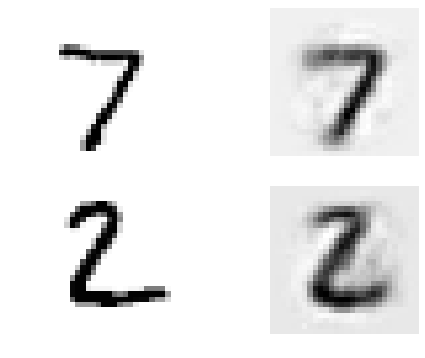

In [13]:
show_reconstructed_digits(X, outputs)

## Unsupervised Pretraining

We can also use undercomplete autoencoders to pretrain lower layers for a neural network when we have don't have very much labelled data. This process is similar to what we did in an earlier chapter, where we froze the layers of a pretrained model. In this case, the autoencoder will be trained on the unlabelled data, its layers will be frozen, and we will train a neural network using these lower layers on the labelled data.

## Denoising Autoencoders

Instead of using undercomplete autoencoders to learn important features, we can also use coding layers that are as larger or larger than the input layers (an *overcomplete* autoencoder) for different sorts of tasks.
